In [51]:
# Jonathan Markey - 1805361

In [52]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from tabulate import tabulate
import pandas as pd

In [53]:
def compute_mean_std(loader): # just computes mean and std
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [54]:
# First part to load dataset and find mean and std
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=50000, shuffle=True, num_workers=2)
original_mean, original_std = compute_mean_std(loader)
print(f"Original Mean: {original_mean}")
print(f"Original Std: {original_std}")

# Transformer with mean and std of dataset
transform_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(original_mean, original_std) 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(original_mean, original_std)
])

# training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Validation split at 10%
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(num_train * 0.1)  # 10% split
v_idx = torch.utils.data.random_split(train_dataset, [split, num_train - split])[0].indices
t_idx = torch.utils.data.random_split(train_dataset, [split, num_train - split])[1].indices
t_split = torch.utils.data.sampler.SubsetRandomSampler(t_idx)
v_split = torch.utils.data.sampler.SubsetRandomSampler(v_idx)

# Applying split and loading data with batching
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=t_split, num_workers=2)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=v_split, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Original Mean: tensor([0.4914, 0.4822, 0.4465])
Original Std: tensor([0.2023, 0.1994, 0.2010])
Files already downloaded and verified
Files already downloaded and verified


In [55]:
# first method for 1 conv to relu to 1 pooling layer
def convolutional_layers1(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

In [56]:
# Second method for implamenting 2 conv to relu to 1 pooling
def convolutional_layers2(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    if in_channels == 3: # for first conv layer since the math update doesnt work
        return nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size, stride, padding),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels*2, kernel_size, stride, padding),
            nn.ReLU(),
            nn.Conv2d(in_channels*2, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

In [57]:
# method to call n fclayers
def fully_connected_layers(in_features, out_features, dropout=0.2):
    return nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.ReLU(),
        nn.Dropout(dropout)
    )

In [58]:
class CNN_Model(nn.Module):
    def __init__(self, num_conv, num_fc, state): # initialisation
        super(CNN_Model, self).__init__()
        if state == 0: # For when you want to have single conv layers
            channels = [3, 32, 64, 128, 256, 512]
            self.conv_layers = nn.Sequential(
                *[convolutional_layers1(channels[i], channels[i+1]) for i in range(num_conv)]
            )
        else: # for when you want to have multiple cov layers
            channels = [3, 64, 256, 1024, 4096, 16384]
            self.conv_layers = nn.Sequential(
                *[convolutional_layers2(channels[i], channels[i+1]) for i in range(num_conv-1)]
            )
            
        conv_dim = 32 // (2**num_conv)
        fcl_input = channels[num_conv] * conv_dim * conv_dim
        # Create the fully connected blocks
        fcl_params = [fcl_input]
        fcl_params.extend([(10+128*n) for n in reversed(range(num_fc))]) # to get it in descending order from n to 10
                
        self.fc_layers = nn.Sequential(
            *[fully_connected_layers(fcl_params[i], fcl_params[i+1]) for i in range(num_fc)],
        )
        
    def forward(self, x): # forward method executes as conv and fcl were sequential
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

In [59]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_gradient = 0.0
    num_parameters = 0  # essentially weights and bias * num layers
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        for param in model.parameters(): # getting gradient magnitudes and num params
            if param.grad is not None:
                total_gradient += torch.sum(torch.abs(param.grad)).item()
                num_parameters += param.numel()
                
        optimizer.step()
        total_loss += loss.item() # getting loss value
    
    ave_loss = total_loss / len(dataloader)
    ave_grad = total_gradient / num_parameters
    return ave_loss, ave_grad

In [60]:
def validate(model, dataloader, criterion, device): 
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            probs = func.softmax(outputs, dim=1) # softmax to transform to prob distribution
            _, predicted = probs.max(1) # getting max prob class
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    ave_loss = total_loss / len(dataloader)
    accuracy = correct / total # counting % correct
    return ave_loss, accuracy

In [61]:
def test(model, dataloader):
    # setting this stuff here so i dont have to call it in the method every time
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    n_classes = 10
    
    confusion_matrix = torch.zeros(n_classes, n_classes) # init conf matrix
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels) # getting loss
            
            total_loss += loss.item()
            
            probs = func.softmax(outputs, dim=1) # softmax again
            _, predicted = probs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1 # manually creating conf matrix by adding 1 every time it is tp, tn, fp, fn
    
    ave_loss = total_loss / len(dataloader)
    
    # getting full now actuals now
    TPs = torch.diag(confusion_matrix)
    FNs = confusion_matrix.sum(dim=1) - TPs
    FPs = confusion_matrix.sum(dim=0) - TPs
    TNs = confusion_matrix.sum() - (TPs + FNs + FPs)
    
    accuracy = correct / total # using % correct for acc instead of tp + tn / total as it was misleading. It was different from acc in val and the TN in the calc included fn from other classes
    
    # CM stats
    #accuracy = (TPs+TNs) / (TPs + TNs + FPs + FNs)
    specificity = (TNs / (TNs + FPs)).mean().item()
    sensitivity = (TPs / (TPs + FNs)).mean().item()
    precision = (TPs / (TPs + FPs)).mean().item()
    f1 = 2 * precision * sensitivity / (precision + sensitivity)
    
    stats = [ave_loss, accuracy, specificity, sensitivity, precision, f1]

    return stats

In [62]:
def print_graph(epochs, train_losses, val_losses, val_accuracies, avg_grad_magnitudes):
    fig, ax1 = plt.subplots(figsize=(8, 3))

    # Training & Validation Loss
    ax1.plot(epochs, train_losses, '-o', label='Training Loss', color='blue')
    ax1.plot(epochs, val_losses, '-o', label='Validation Loss', color='green')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    # Accuracy
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Accuracy (%)', color='red')
    ax2.plot(epochs, val_accuracies, '-o', label='Validation Accuracy', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Ave Grad Mag
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # stop overlapping
    ax3.set_ylabel('Avg Gradient Magnitude', color='purple')
    ax3.plot(epochs, avg_grad_magnitudes, '-o', label='Avg Gradient Magnitude', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    plt.title('Training & Validation Loss, Accuracy and Average Gradient Magnitude')
    plt.show()

In [63]:
def CNN_MODEL_TRAIN_VALIDATION(num_conv, num_fc, state): # actual model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # doesn't work ov VSC for some reason.
    model = CNN_Model(num_conv, num_fc, state).to(device) # calling model
    criterion = nn.CrossEntropyLoss() # initialising loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    if num_conv == 5:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9) # just here for testing if higher lr is needed to stop vanishing grads
    num_epochs = 50 #max epochs

    # results
    train_losses = []
    avg_grad_magnitudes = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, avg_grad = train(model, train_loader, criterion, optimizer, device) # calling training process
        val_loss, val_accuracy = validate(model, test_loader, criterion, device) # calling validation process
        
        train_losses.append(train_loss)
        avg_grad_magnitudes.append(avg_grad)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {train_loss:.4f} | Average Gradient: {avg_grad:.10f} | Validation loss: {val_loss:.4f} | Validation accuracy: {val_accuracy:.2f}% | Current LR: {optimizer.param_groups[0]['lr']}" )
        
        scheduler.step(val_loss) # lr scheduler step is plateau after 4
        
        if optimizer.param_groups[0]['lr'] <= 0.00001: #stopping criteria
            print("Model training stopped")
            break

    torch.save(model.state_dict(), 'modelC'+str(num_conv)+'F'+str(num_fc)+'S'+str(state)+'.pth') # Save the model if running out of time, takes up to like 30 mins per model.

    epochs = range(1, len(train_losses) + 1) # need this for early stopping so graph still works
    #graph = print_graph(epochs, train_losses, val_losses, val_accuracies, avg_grad_magnitudes)
    return epochs, train_losses, val_losses, val_accuracies, avg_grad_magnitudes, model

Epoch 1/50 | Train loss: 1.9523 | Average Gradient: 0.0013758041 | Validation loss: 1.5893 | Validation accuracy: 47.23% | Current LR: 0.01
Epoch 2/50 | Train loss: 1.6732 | Average Gradient: 0.0018992174 | Validation loss: 1.4013 | Validation accuracy: 55.66% | Current LR: 0.01
Epoch 3/50 | Train loss: 1.5168 | Average Gradient: 0.0021867550 | Validation loss: 1.2804 | Validation accuracy: 61.53% | Current LR: 0.01
Epoch 4/50 | Train loss: 1.4297 | Average Gradient: 0.0022596168 | Validation loss: 1.0807 | Validation accuracy: 65.53% | Current LR: 0.01
Epoch 5/50 | Train loss: 1.3510 | Average Gradient: 0.0023082580 | Validation loss: 0.9896 | Validation accuracy: 70.23% | Current LR: 0.01
Epoch 6/50 | Train loss: 1.2865 | Average Gradient: 0.0023247374 | Validation loss: 0.9543 | Validation accuracy: 71.13% | Current LR: 0.01
Epoch 7/50 | Train loss: 1.2596 | Average Gradient: 0.0023331815 | Validation loss: 0.9261 | Validation accuracy: 72.40% | Current LR: 0.01
Epoch 8/50 | Train l

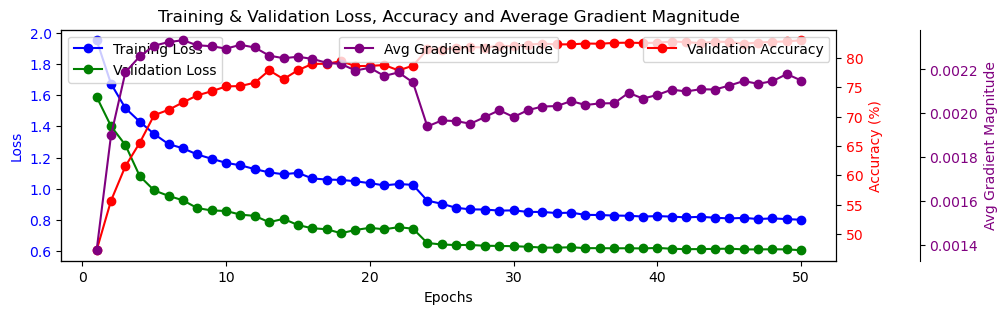

In [16]:
m1_epochs, m1_train_losses, m1_val_losses, m1_val_accuracies, m1_avg_grad_magnitudes, m1_model = CNN_MODEL_TRAIN_VALIDATION(3,2,0)
Model1_test = ['Model1', 'Test']
Model1_test.extend(test(m1_model, test_loader))
Model1_train = ['Model1', 'Train']
Model1_train.extend(test(m1_model, train_loader))

[1.9522709682245145, 1.6731834536926313, 1.5168434867466039, 1.429735041308132, 1.351048006252809, 1.2864906790412285, 1.2595746586607262, 1.2197071889584714, 1.1923261504958977, 1.1660857380113818, 1.1503269279545003, 1.1259012701497837, 1.1048860480500893, 1.0931562063368885, 1.1020305519076912, 1.0660626021298496, 1.0589867241003297, 1.0568031983619386, 1.0478863993405618, 1.0360599446364425, 1.0216180431571873, 1.0306084566664966, 1.024880706078627, 0.9236517083534802, 0.9038552181287245, 0.8779611149379476, 0.8678253050470217, 0.8668574100275609, 0.8598583247935907, 0.8613691464997828, 0.8515431874601002, 0.8513840488581494, 0.8440840796313502, 0.8468434487215497, 0.8326218729330734, 0.8317002729428086, 0.8282057546417821, 0.826919331511652, 0.8218038670972667, 0.8247907324270769, 0.8214316021820361, 0.8163978247903287, 0.8203353049572218, 0.8142808398062532, 0.8097331907219169, 0.8132227557203309, 0.806050617755814, 0.8099381409754808, 0.8055226857858625, 0.8013338893651962]
[1.5

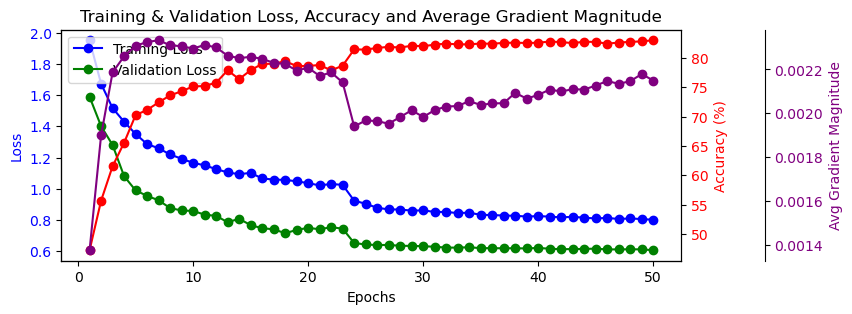

In [31]:
print(m1_train_losses)
print(m1_val_losses)
print(m1_val_accuracies)
print(m1_avg_grad_magnitudes)
print_graph(m1_epochs, m1_train_losses, m1_val_losses, m1_val_accuracies, m1_avg_grad_magnitudes)

Epoch 1/50 | Train loss: 2.0175 | Average Gradient: 0.0011255895 | Validation loss: 1.6603 | Validation accuracy: 42.56% | Current LR: 0.01
Epoch 2/50 | Train loss: 1.6971 | Average Gradient: 0.0017490611 | Validation loss: 1.4582 | Validation accuracy: 54.81% | Current LR: 0.01
Epoch 3/50 | Train loss: 1.5360 | Average Gradient: 0.0020088153 | Validation loss: 1.2861 | Validation accuracy: 60.00% | Current LR: 0.01
Epoch 4/50 | Train loss: 1.4285 | Average Gradient: 0.0021449494 | Validation loss: 1.1026 | Validation accuracy: 66.53% | Current LR: 0.01
Epoch 5/50 | Train loss: 1.3506 | Average Gradient: 0.0022167022 | Validation loss: 1.0926 | Validation accuracy: 66.14% | Current LR: 0.01
Epoch 6/50 | Train loss: 1.2816 | Average Gradient: 0.0022532881 | Validation loss: 0.9752 | Validation accuracy: 71.49% | Current LR: 0.01
Epoch 7/50 | Train loss: 1.2360 | Average Gradient: 0.0022867761 | Validation loss: 0.9328 | Validation accuracy: 72.54% | Current LR: 0.01
Epoch 8/50 | Train l

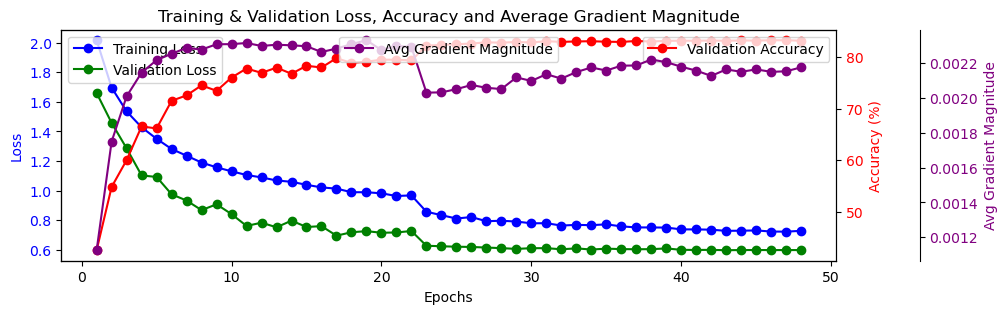

In [17]:
m2_epochs, m2_train_losses, m2_val_losses, m2_val_accuracies, m2_avg_grad_magnitudes, m2_model = CNN_MODEL_TRAIN_VALIDATION(4,2,0)
Model2_test = ['Model2', 'Test']
Model2_test.extend(test(m2_model, test_loader))
Model2_train = ['Model2', 'Train']
Model2_train.extend(test(m2_model, train_loader))

[2.017524890093641, 1.6971324617889794, 1.5360028694637797, 1.428542579270222, 1.350606444376436, 1.2815818373452534, 1.2360491294583136, 1.1899329204620286, 1.1575413214212114, 1.1306427581320433, 1.105675783008337, 1.0894010616466403, 1.0686238162558188, 1.0596215301616625, 1.0392813437872312, 1.0217456887899474, 1.0134207173250616, 0.9893628942187537, 0.9889351633292708, 0.9818575973199173, 0.9636065160686319, 0.9677580890499733, 0.8571670563806865, 0.833886931523342, 0.8112544712441211, 0.8211832067675211, 0.7929839347489178, 0.7963264033367689, 0.7906790063716471, 0.7789108453064479, 0.779553273184733, 0.7635310554760508, 0.7682476607574658, 0.7662231951782649, 0.7718556026547131, 0.7581518020226874, 0.7511438960209489, 0.7507802190005102, 0.7499842891384932, 0.7378210411830382, 0.7374574059451168, 0.7357531719079072, 0.7277236501686275, 0.7289610085585578, 0.7304941654120657, 0.7232058320660144, 0.7223873252091422, 0.7280901080971076]
[1.6603176343213222, 1.458244191613167, 1.286

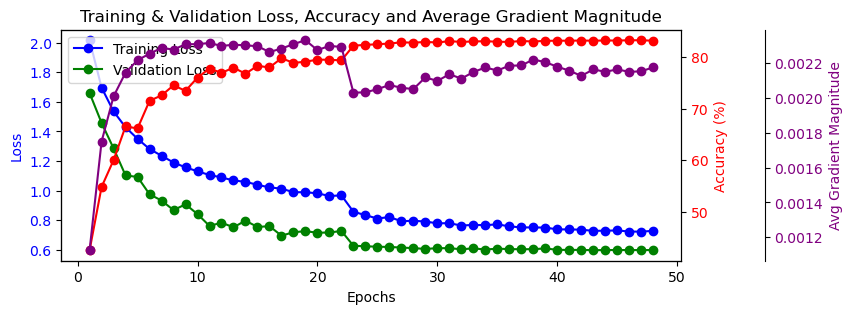

In [34]:
print(m2_train_losses)
print(m2_val_losses)
print(m2_val_accuracies)
print(m2_avg_grad_magnitudes)
print_graph(m2_epochs, m2_train_losses, m2_val_losses, m2_val_accuracies, m2_avg_grad_magnitudes)

Epoch 1/50 | Train loss: 2.0392 | Average Gradient: 0.0002868718 | Validation loss: 1.5632 | Validation accuracy: 48.20% | Current LR: 0.01
Epoch 2/50 | Train loss: 1.6904 | Average Gradient: 0.0004472624 | Validation loss: 1.3249 | Validation accuracy: 58.15% | Current LR: 0.01
Epoch 3/50 | Train loss: 1.5076 | Average Gradient: 0.0005163838 | Validation loss: 1.1139 | Validation accuracy: 66.65% | Current LR: 0.01
Epoch 4/50 | Train loss: 1.3770 | Average Gradient: 0.0005376463 | Validation loss: 1.0277 | Validation accuracy: 69.04% | Current LR: 0.01
Epoch 5/50 | Train loss: 1.2814 | Average Gradient: 0.0005553059 | Validation loss: 1.0072 | Validation accuracy: 69.73% | Current LR: 0.01
Epoch 6/50 | Train loss: 1.2135 | Average Gradient: 0.0005445860 | Validation loss: 0.8369 | Validation accuracy: 74.97% | Current LR: 0.01
Epoch 7/50 | Train loss: 1.1542 | Average Gradient: 0.0005402532 | Validation loss: 0.7805 | Validation accuracy: 76.76% | Current LR: 0.01
Epoch 8/50 | Train l

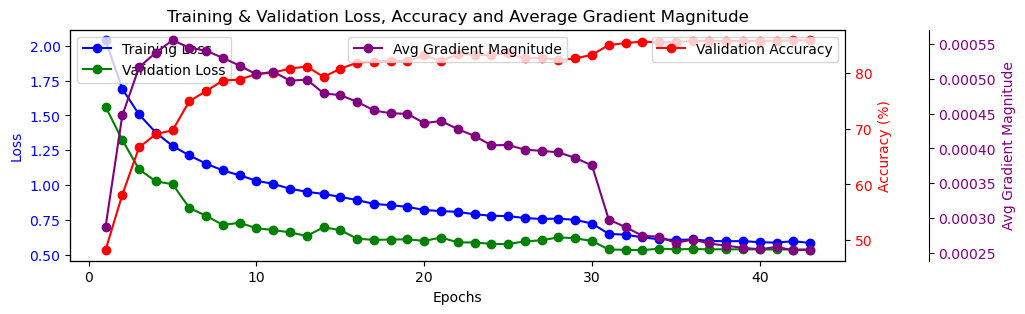

In [18]:
m3_epochs, m3_train_losses, m3_val_losses, m3_val_accuracies, m3_avg_grad_magnitudes, m3_model = CNN_MODEL_TRAIN_VALIDATION(3,3,1)
print_graph(m3_epochs, m3_train_losses, m3_val_losses, m3_val_accuracies, m3_avg_grad_magnitudes)
Model3_test = ['Model3', 'Test']
Model3_test.extend(test(m3_model, test_loader))
Model3_train = ['Model3', 'Train']
Model3_train.extend(test(m3_model, train_loader))

[2.039243973283605, 1.690425493331118, 1.5075938025997444, 1.377016439949247, 1.2813696817240932, 1.2134761529212648, 1.1542097104035995, 1.105945350094275, 1.0708954633975571, 1.0319774247367273, 1.0095101367174224, 0.9746720691804182, 0.9529139618812636, 0.9371651651083746, 0.9164255511184985, 0.8933915854008361, 0.8661462300541726, 0.8567237338389863, 0.8448153538206085, 0.8224952027878978, 0.8145812789655544, 0.8092318806712601, 0.7918229782953858, 0.7814244541593574, 0.7787465962835334, 0.764769518155266, 0.7580983906730332, 0.7609220288101245, 0.7516194315288555, 0.7252907590855929, 0.6515222514598545, 0.645360840336335, 0.6266935314263471, 0.6124805294146592, 0.6078555713704025, 0.6115420785817233, 0.6010648710229858, 0.5984436559533193, 0.5996054859874262, 0.5916811012747613, 0.5884924031667073, 0.59921900362877, 0.5858201870948754]
[1.5631676130234056, 1.3248611286187628, 1.1138539739475128, 1.0277276828790167, 1.0072241801365165, 0.8369136638702102, 0.7805450655472507, 0.7154

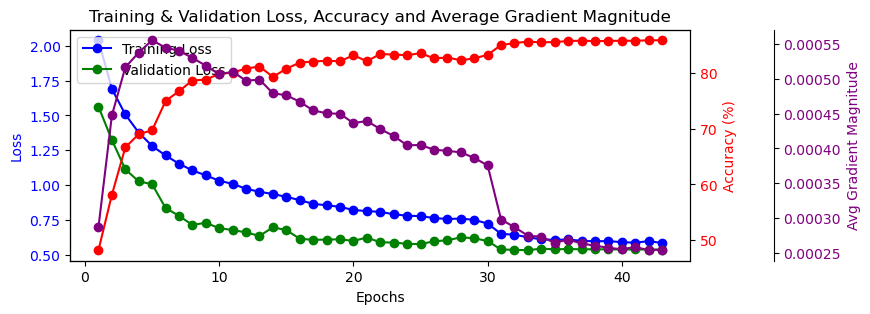

In [33]:
print(m3_train_losses)
print(m3_val_losses)
print(m3_val_accuracies)
print(m3_avg_grad_magnitudes)
print_graph(m3_epochs, m3_train_losses, m3_val_losses, m3_val_accuracies, m3_avg_grad_magnitudes)

Epoch 1/50 | Train loss: 2.2754 | Average Gradient: 0.0000370947 | Validation loss: 2.1221 | Validation accuracy: 25.77% | Current LR: 0.01
Epoch 2/50 | Train loss: 1.9764 | Average Gradient: 0.0002361976 | Validation loss: 1.6640 | Validation accuracy: 45.08% | Current LR: 0.01
Epoch 3/50 | Train loss: 1.7230 | Average Gradient: 0.0003390752 | Validation loss: 1.4852 | Validation accuracy: 52.01% | Current LR: 0.01
Epoch 4/50 | Train loss: 1.5352 | Average Gradient: 0.0004224763 | Validation loss: 1.2762 | Validation accuracy: 58.64% | Current LR: 0.01
Epoch 5/50 | Train loss: 1.3906 | Average Gradient: 0.0004475113 | Validation loss: 1.0304 | Validation accuracy: 69.21% | Current LR: 0.01
Epoch 6/50 | Train loss: 1.2667 | Average Gradient: 0.0004782926 | Validation loss: 0.9456 | Validation accuracy: 71.33% | Current LR: 0.01
Epoch 7/50 | Train loss: 1.1898 | Average Gradient: 0.0004819778 | Validation loss: 0.8917 | Validation accuracy: 73.43% | Current LR: 0.01
Epoch 8/50 | Train l

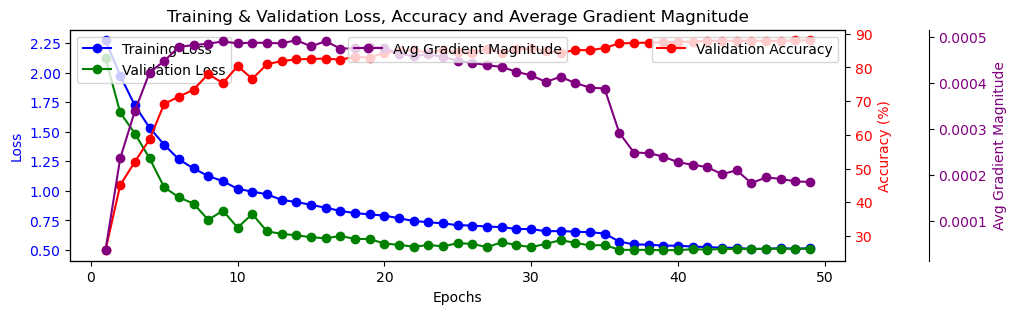

In [19]:
m4_epochs, m4_train_losses, m4_val_losses, m4_val_accuracies, m4_avg_grad_magnitudes, m4_model = CNN_MODEL_TRAIN_VALIDATION(4,3,1)
print_graph(m4_epochs, m4_train_losses, m4_val_losses, m4_val_accuracies, m4_avg_grad_magnitudes)
Model4_test = ['Model4', 'Test']
Model4_test.extend(test(m4_model, test_loader))
Model4_train = ['Model4', 'Train']
Model4_train.extend(test(m4_model, train_loader))

[2.2754193781451746, 1.9764361379837447, 1.7229770907962865, 1.5351638314737515, 1.390582444569604, 1.2666757897558538, 1.1898011027581312, 1.1257453107867728, 1.0826821943575686, 1.017183661884205, 0.9944073160771619, 0.9710545560175722, 0.9237925281578844, 0.9058987327258695, 0.8816973172890191, 0.8579635850407861, 0.8304771557873623, 0.8118957937695086, 0.801215083676983, 0.7910966894335367, 0.7684267628726296, 0.7454691045409576, 0.7348735334605656, 0.7249695155346259, 0.7097210600464181, 0.7067467251115225, 0.6984211843122136, 0.6934338011355563, 0.6773890651317991, 0.676816925660453, 0.6587119501253421, 0.6600910171189092, 0.6547118258154527, 0.6506436221640218, 0.6392529691802338, 0.5710678673772649, 0.5471761399372057, 0.5452061511830173, 0.5366657284215431, 0.5366195816631344, 0.5283569352574308, 0.5249363222498108, 0.5190019520880985, 0.518265430117026, 0.5078586485998048, 0.5095783739816397, 0.5150754291733558, 0.5098762625024061, 0.5150346563790332]
[2.122108193719463, 1.66

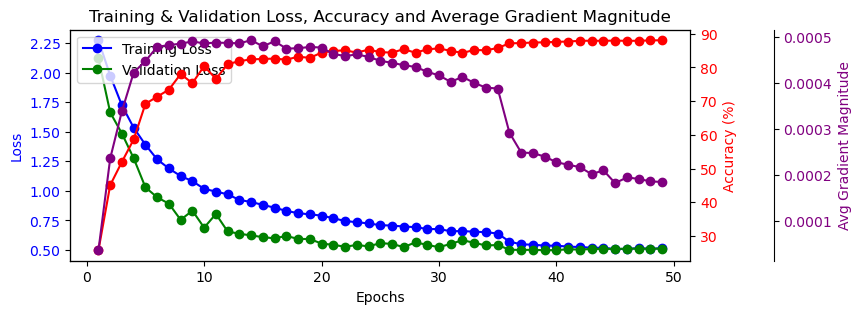

In [35]:
print(m4_train_losses)
print(m4_val_losses)
print(m4_val_accuracies)
print(m4_avg_grad_magnitudes)
print_graph(m4_epochs, m4_train_losses, m4_val_losses, m4_val_accuracies, m4_avg_grad_magnitudes)

Epoch 1/50 | Train loss: 2.3026 | Average Gradient: 0.0000000123 | Validation loss: 2.3026 | Validation accuracy: 10.00% | Current LR: 0.1
Epoch 2/50 | Train loss: 2.3026 | Average Gradient: 0.0000000000 | Validation loss: 2.3026 | Validation accuracy: 10.00% | Current LR: 0.1
Epoch 3/50 | Train loss: 2.3026 | Average Gradient: 0.0000000000 | Validation loss: 2.3026 | Validation accuracy: 10.00% | Current LR: 0.1
Epoch 4/50 | Train loss: 2.3026 | Average Gradient: 0.0000000000 | Validation loss: 2.3026 | Validation accuracy: 10.00% | Current LR: 0.1
Epoch 5/50 | Train loss: 2.3026 | Average Gradient: 0.0000000000 | Validation loss: 2.3026 | Validation accuracy: 10.00% | Current LR: 0.1
Epoch 6/50 | Train loss: 2.3026 | Average Gradient: 0.0000000000 | Validation loss: 2.3026 | Validation accuracy: 10.00% | Current LR: 0.1
Epoch 00006: reducing learning rate of group 0 to 1.0000e-02.
Epoch 7/50 | Train loss: 2.3026 | Average Gradient: 0.0000000000 | Validation loss: 2.3026 | Validation 

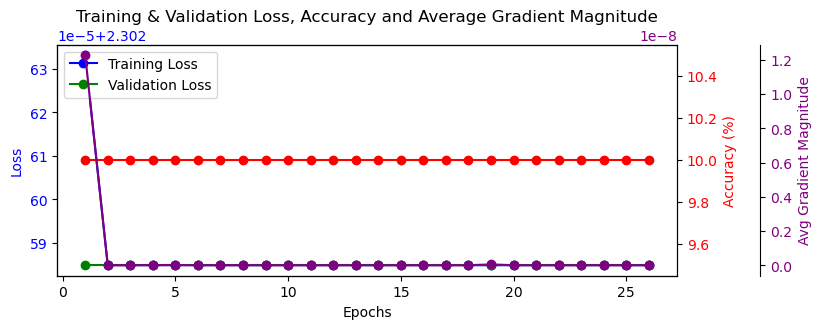

In [40]:
m5_epochs, m5_train_losses, m5_val_losses, m5_val_accuracies, m5_avg_grad_magnitudes, m5_model = CNN_MODEL_TRAIN_VALIDATION(5,3,1)
print_graph(m5_epochs, m5_train_losses, m5_val_losses, m5_val_accuracies, m5_avg_grad_magnitudes)
Model5_test = ['Model5', 'Test']
Model5_test.extend(test(m5_model, test_loader))
Model5_train = ['Model5', 'Train']
Model5_train.extend(test(m5_model, train_loader))
print(m5_train_losses)
print(m5_val_losses)
print(m5_val_accuracies)
print(m5_avg_grad_magnitudes)
print_graph(m5_epochs, m5_train_losses, m5_val_losses, m5_val_accuracies, m5_avg_grad_magnitudes)

In [21]:
data = [Model1_test, Model1_train, Model2_test, Model2_train, Model3_test, Model3_train, Model4_test, Model4_train, Model5_test, Model5_train]

headers = ['Model', 'Dataset', 'Avg Loss', 'Accuracy', 'Specificity', 'Sensitivity', 'Precision', 'F1 Score']
print(tabulate(data, headers=headers))

Model    Dataset      Avg Loss    Accuracy    Specificity    Sensitivity    Precision    F1 Score
-------  ---------  ----------  ----------  -------------  -------------  -----------  ----------
Model1   Test        0.605963    0.8299          0.9811         0.8299       0.830042    0.829971
Model1   Train       0.381867    0.902778        0.989197       0.902792     0.90329     0.903041
Model2   Test        0.597834    0.8312          0.981244       0.8312       0.830523    0.830861
Model2   Train       0.325501    0.916           0.990667       0.915999     0.916       0.915999
Model3   Test        0.539181    0.8589          0.984322       0.8589       0.858905    0.858902
Model3   Train       0.127871    0.970822        0.996758       0.970828     0.970811    0.970819
Model4   Test        0.511445    0.8809          0.986767       0.8809       0.881082    0.880991
Model4   Train       0.0541082   0.988378        0.998709       0.988377     0.988393    0.988385
Model5   Test       